In [13]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp020'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


## read data

In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v2/train_20000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v2/test_20000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)

sub_df = pd.read_csv(root_dir/'indoor-location-navigation/sample_submission.csv', index_col=0)

In [6]:

train_df = train_df.rename(columns={'wp_tmestamp':'timestamp', 'path_id':'path'})
test_df = test_df.rename(columns={'wp_tmestamp':'timestamp', 'path_id':'path'})

train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32})
test_df = test_df.astype({'timestamp':int})

In [7]:
train_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,y,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff
0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,156.842239,1578466134278,113.615387,156.634796,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45
1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,156.842239,1578466136278,112.655884,156.358200,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12
2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,156.842239,1578466138278,111.936256,156.150772,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29
3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,156.842239,1578466140278,110.976761,155.874176,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72
4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,...,154.629517,1578466142278,110.017258,155.597580,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,1a04593c547b59266cbf0e599f87cda4f67c5ad4,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,107.011642,1573892866000,128.925217,109.018059,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38
256745,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,...,111.526085,1573892868000,130.645798,110.522873,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,1098,126
256746,18336f0964fbd470a2ee7116d33b96946c633999,18

In [8]:
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_95,timediff_96,timediff_97,timediff_98,timediff_99,timestamp,path,site_id,timediff,site_path_timestamp
0,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,ab150ecf6d972b476aeab16317bed6189d9f7cce,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,01e78c97f2c04cdbc7c4159158bb125a9bb558ff,...,1749.0,1374.0,1375.0,9179.0,15614.0,1578474563646,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-2331,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,18272.0,354.0,353.0,359.0,353.0,1578474572654,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-491,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,1701.0,1702.0,1702.0,9442.0,9441.0,1578474578963,046cfa46be49fc10834815c6,5a0546857ecc773753327266,612,5a0546857ecc773753327266_046cfa46be49fc1083481...
3,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,19.0,19.0,399.0,704.0,8322.0,1578474582400,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-824,5a0546857ecc773753327266_046cfa46be49fc1083481...
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,26571eb257b6a34b6beb93c05768e751d19279a6,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,2013.0,1095.0,1091.0,645.0,647.0,1578474585965,046cfa46be49fc10834815c6,5a0546857ecc773753327266,254,5a0546857ecc773753327266_046cfa46be49fc1083481...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,0f927dce74ec3475c7a39299e5bffab222ca665d,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,efa1fe97c4b2a6c57d98de9c236a109032ceb839,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,c72257cf75d6a411225948bbc4e37ad554e7beda,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,3788.0,7589.0,7774.0,3517.0,1409.0,1573731143256,fd64de8c4a2fc5ebb0e9f412,5dc8cea7659e181adb076a3f,925,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...
10129,8e69018f6343506344ab13646ccd9447fc2ffb19,0f927dce74ec3475c7a39299e5bffab222ca665d,efa1fe97c4b2a6c57d98de9c236a109032ceb839,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,8e69018f6343506344ab

In [9]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない

In [10]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids = list(set(wifi_bssids))
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61357
BSSID TYPES(test): 30658
BSSID TYPES(all): 61421


In [11]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 98
RSSI TYPES(test): 77
RSSI TYPES(all): 175


## preprocessing

In [12]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
        # output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？ embeddingのpadding用のダミー変数？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df['site_id_str'] = input_df['site_id'].copy()
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    # output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

In [13]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [14]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.ixy = df[['ix', 'iy']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
            timediff = df['timediff'].values.astype(np.float32)
            self.weight = 1- (timediff/np.max(timediff))  # lossにかける重み。timediffが大きいほど小さくなる
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
    
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'ixy':self.ixy[idx],
                'floor':self.floor[idx],
                'weight': self.weight[idx]
            }
        else:
            target = {}
        return feature, target

In [15]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, wifi_bssids_size, site_count=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(wifi_bssids_size, embedding_dim),
            nn.Flatten(start_dim=-2)            
        )
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(site_count, 64),
            nn.Flatten(start_dim=-1)           
        )

        # bssid, site, rssiの出力size
        # feature_size = 2 + (2 * NUM_FEATS * embedding_dim)
        feature_size = 64 + (2 * NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_rssi_bssid = self.embedding_layer1(x['RSSI_BSSID_FEATS'])
        x_site_id = self.embedding_layer2(x['site_id'])
        # x_rssi = self.linear_layer1(x['RSSI_FEATS'])
        x = torch.cat([x_rssi_bssid, x_site_id], dim=-1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        return {"xy": xy, "floor": floor}

In [16]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [17]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss(reduction='none')

    def forward(self, input, target, weight):  # weight:timediffによる重みづけ
        input = input.float()
        target = target.float()
        weight = torch.stack((weight, weight), 1).float()  # x,y分でstack
        loss = self.loss(input, target) * weight  # timediffが大きいもののlossはあまり計算しないようにする
        return loss.mean()

In [18]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    
    
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [19]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["ixy"], y['weight'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["ixy"], y['weight'])
        # f_loss = self.f_criterion(output["floor"], y["floor"], y['weight'])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)

        impe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['ixy'][:, 0]), to_np(y['ixy'][:, 1]), 0)

        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        # self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'iMPE/val', impe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [20]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [21]:
oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = model_selection.GroupKFold(n_splits=N_SPLITS)

train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in gkf.split(train.loc[:, 'path'], groups=train.loc[:, 'path'])]
# 今回はtargetを均等に分ける必要はなくpathが均等に分かれればいいのでskf.split()にpathを与えている。
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_df = train.loc[trn_idx_for_train, :].reset_index(drop=True)
    trn_df = trn_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor','timediff']]
    
    val_df = train.loc[val_idx_for_train, :].reset_index(drop=True)
    val_df = val_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor','timediff']]

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = LSTMModel(wifi_bssids_size, site_count)  # +1としているのはLEを1スタートで始めているため
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='indoor', notes=NOTES, entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config['model_name'] = model_name
    wandb_config['LB'] = None
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()  
    oof_df = train.loc[val_idx_for_train, ['timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oof_df["oof_x"] = oof_x
    oof_df["oof_y"] = oof_y
    oof_df["oof_floor"] = oof_f
    oofs.append(oof_df)
    
    # 補間前のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['x'].values, oof_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    # 補間後のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['ix'].values, oof_df['iy'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############n

    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    # test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)

    if fold != 4:
        wandb.finish()

Fold 0
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name         | Type            | Params
-------------------------------------------------
0 | model        | LSTMModel       | 6.8 M 
1 | xy_criterion | WeightedMSELoss | 0     
2 | f_criterion  | WeightedMSELoss | 0     
-------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.193    Total estimated model params size (MB)
fold 0: mean position error 7.326018743914314
fold 0: mean position error 6.851524464459591


Loss/val,36.92974
Loss/xy,36.92974
MPE/val,7.32536
iMPE/val,6.85076
epoch,157
trainer/global_step,63515
_runtime,755
_timestamp,1619239024
_step,157


Loss/val,█▆▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▆▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▇▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iMPE/val,█▇▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 1
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name         | Type            | Params
-------------------------------------------------
0 | model        | LSTMModel       | 6.8 M 
1 | xy_criterion | WeightedMSELoss | 0     
2 | f_criterion  | WeightedMSELoss | 0     
-------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.193    Total estimated model params size (MB)
fold 1: mean position error 7.386301728334956
fold 1: mean position error 6.928207156767283


Loss/val,39.73526
Loss/xy,39.73526
MPE/val,7.38583
iMPE/val,6.92773
epoch,135
trainer/global_step,54671
_runtime,652
_timestamp,1619239686
_step,135


Loss/val,█▅▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▆▆▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iMPE/val,█▆▆▆▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 2
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name         | Type            | Params
-------------------------------------------------
0 | model        | LSTMModel       | 6.8 M 
1 | xy_criterion | WeightedMSELoss | 0     
2 | f_criterion  | WeightedMSELoss | 0     
-------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.193    Total estimated model params size (MB)
fold 2: mean position error 7.56488558909445
fold 2: mean position error 7.107524951314509


Loss/val,43.58604
Loss/xy,43.58604
MPE/val,7.56541
iMPE/val,7.10824
epoch,115
trainer/global_step,46631
_runtime,558
_timestamp,1619240254
_step,115


Loss/val,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iMPE/val,█▆▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 3
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name         | Type            | Params
-------------------------------------------------
0 | model        | LSTMModel       | 6.8 M 
1 | xy_criterion | WeightedMSELoss | 0     
2 | f_criterion  | WeightedMSELoss | 0     
-------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.193    Total estimated model params size (MB)
fold 3: mean position error 7.39491723466407
fold 3: mean position error 6.913011197663097


Loss/val,39.41698
Loss/xy,39.41698
MPE/val,7.39343
iMPE/val,6.91141
epoch,169
trainer/global_step,68339
_runtime,823
_timestamp,1619241087
_step,169


Loss/val,█▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iMPE/val,█▆▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Fold 4
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name         | Type            | Params
-------------------------------------------------
0 | model        | LSTMModel       | 6.8 M 
1 | xy_criterion | WeightedMSELoss | 0     
2 | f_criterion  | WeightedMSELoss | 0     
-------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.193    Total estimated model params size (MB)
fold 4: mean position error 7.425694755496699
fold 4: mean position error 6.944732979220627


## validation

In [22]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
oofs_df.to_csv("oof.csv", index=False)
oofs_df

,timestamp,x,y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.703384,35.896935,0.050015,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.085648,33.331852,0.051606,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.479462,31.129669,0.055450,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,83.046516,28.305487,0.105547,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.903687,25.688530,0.113001,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.722580,102.947876,0.051249,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.081009,104.781708,0.048083,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.765640,101.219009,0.045495,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.395981,99.917511,0.047748,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [23]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

CV:7.419562977849963


In [24]:
# waypoint補正後のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['CV-i'] = oof_score
print(f"CV:{oof_score}")

CV:6.949000288219233


In [25]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    sub = pd.concat(predictions).groupby('site_path_timestamp').mean()  # 平均でいいんだっけ？
    sub.index = sub_df.index
else:
    sub = predictions[0]
    sub.index = sub_df.index
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,89.343513,103.353050
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.037498,102.574326
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.473686,105.721306
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.442810,108.274948
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.056442,106.500748
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,215.664688,97.607384
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,212.975098,98.706818
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,207.825668,105.833908


In [26]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv(root_dir / 'simple-99-accurate-floor-model/submission.csv')
sub['floor'] = simple_accurate_99['floor'].values
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,89.343513,103.353050
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.037498,102.574326
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.473686,105.721306
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.442810,108.274948
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.056442,106.500748
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,215.664688,97.607384
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,212.975098,98.706818
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,207.825668,105.833908


## testのwaypointを予測結果(wifi)から再度線形補完

In [27]:
import sys 
sys.path.append("../../")
from multiprocessing import Pool
from src.io_f import read_data_file
from scipy import interpolate

# timestampとwaypointを元に線形補完しtarget_timestampに対応するtarget_waypointを求める　
def wifi_waypoint_by_linear_interpolation(
    observed_timestamp: np.ndarray, 
    observed_x:np.ndarray, 
    observed_y:np.ndarray, 
    target_timestamp:np.ndarray, 
    delta_time=500
    ):
    """
    observed: すでに知っている情報
    observed-timestamp,x,yは全て同じ要素数となる

    observedの情報からfitting関数を作成
    """
    target_waypoint_list = []
    num_interpolation = len(observed_timestamp) - 1  # 補完回数 
    # 各waypoint間で線形補完
    for i in range(num_interpolation):
        # 潜在的なtimestampを作成(これのどれかにwifiを当てはめるような形)
        n_split = int((max(observed_timestamp[i:i+2]) - min(observed_timestamp[i:i+2])) / delta_time) + 2  # delta_time刻みとなるように分割数を指定(+2は始点と終点分)
        latent_timestamp = np.linspace(min(observed_timestamp[i:i+2]), max(observed_timestamp[i:i+2]), n_split).astype(int) 
        
        # xが昇順の場合はlatentも昇順になるようにする
        if observed_x[i] < observed_x[i+1]:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)
        # xが降順の場合はlatentも降順になるようにする
        else:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)[::-1]
        
        # 線形補完関数の適用
        fitting_func = interpolate.interp1d(observed_x[i:i+2], observed_y[i:i+2])

        # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
        target_x = []
        target_y = []

        # 区間内のwifiデータのみ考える
        if i == num_interpolation-1:
            # pathの最後の区間にobserved timestampより未来にあるtimestampに対処
            target_idx = min(observed_timestamp[i:i+2]) <= target_timestamp
        elif i == 0:
            # pathの最初の区間にobserved timestampより過去にあるtimestampに対処
            target_idx = target_timestamp < max(observed_timestamp[i:i+2])
        else:
            target_idx = (min(observed_timestamp[i:i+2]) <= target_timestamp) & (target_timestamp < max(observed_timestamp[i:i+2]))
        target_use_timestamp = target_timestamp[target_idx]

        # timestampが最も近いものをtarget waypointとして取得
        for t in target_use_timestamp:
            idx = np.abs(latent_timestamp - t).argmin()  # targetとtimestampが最も近いものをlatentから取得
            target_x.append(latent_x[idx])
            # 原因はよくわからないがfittingするとnanが発生する場合がある
            # その場合は元の値をそのまま使う
            if np.isnan(fitting_func(latent_x[idx])).sum() > 0:
                # print('yに欠損値あり')
                idx = np.abs(observed_timestamp - t).argmin()  # 0→wifiの最初のtimestampで問題が起きている
                target_y.append(observed_y[idx])
                
            else:
                target_y.append(fitting_func(latent_x[idx]))

        assert len(target_x) == len(target_y)
        target_waypoint = np.stack([target_x, target_y], axis=1)
        target_waypoint_list.append(target_waypoint)

    target_waypoint = np.concatenate(target_waypoint_list)
    return target_waypoint

In [28]:
test_df['site_path_timestamp'] = sub.index
test_df = test_df.merge(sub, on="site_path_timestamp")
test_df['wifi_timestamp'] = test_df['timestamp'].astype(int) - test_df['timediff'].astype(int)
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_99,timestamp,path,site_id,timediff,site_path_timestamp,floor,x,y,wifi_timestamp
0,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,ab150ecf6d972b476aeab16317bed6189d9f7cce,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,01e78c97f2c04cdbc7c4159158bb125a9bb558ff,...,15614.0,1578474563646,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-2331,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.343513,103.353050,1578474565977
1,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,353.0,1578474572654,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-491,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.037498,102.574326,1578474573145
2,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,9441.0,1578474578963,046cfa46be49fc10834815c6,5a0546857ecc773753327266,612,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.473686,105.721306,1578474578351
3,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,8322.0,1578474582400,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-824,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,88.442810,108.274948,1578474583224
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,26571eb257b6a34b6beb93c05768e751d19279a6,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,647.0,1578474585965,046cfa46be49fc10834815c6,5a0546857ecc773753327266,254,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.056442,106.500748,1578474585711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,0f927dce74ec3475c7a39299e5bffab222ca665d,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,efa1fe97c4b2a6c57d98de9c236a109032ceb839,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,c72257cf75d6a411225948bbc4e37ad554e7beda,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,1409.0,1573731143256,fd64de8c4a2fc5ebb0e9f412,5dc8cea7659e181adb076a3f,925,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,215.664688,97.607384,1573731142331
10129,8e69018f6343506344ab13646ccd9447fc2ffb19,0f927dce74ec3475c7a39299e5bffab222ca665d,efa1fe97c4b2a6c57d98de9c236a109032ceb839,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255b

9 9


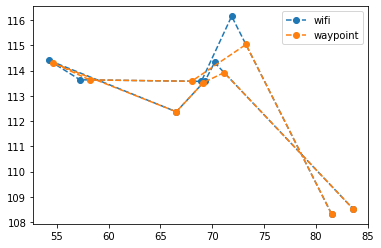

In [29]:
# 線形補完の例
path = test_df['path'].unique()[23]  #15
df = test_df[test_df['path']==path]

waypoint = wifi_waypoint_by_linear_interpolation(
    observed_timestamp=df['wifi_timestamp'].astype(int).values, 
    observed_x=df['x'].values,
    observed_y=df['y'].values, 
    target_timestamp=df['timestamp'].astype(int).values
    )
print(len(df), len(waypoint))

import matplotlib.pyplot as plt
# print(df["timestamp"].astype(int) - df["timestamp"].astype(int).values[0])
plt.plot(df["x"].values, df["y"].values, ls='--', marker="o", label='wifi')
plt.plot(waypoint[:,0], waypoint[:,1], ls='--', marker="o", label='waypoint')
plt.legend()

In [30]:
# 線形補完でwaypointを修正
waypoint_dfs = []
for path,df in test_df.groupby('path'):  #15
    tmp_waypoint = wifi_waypoint_by_linear_interpolation(
        observed_timestamp=df['wifi_timestamp'].astype(int).values, 
        observed_x=df['x'].values,
        observed_y=df['y'].values, 
        target_timestamp=df['timestamp'].astype(int).values
        )
    df['_x'] = tmp_waypoint[:,0]
    df['_y'] = tmp_waypoint[:,1]
    waypoint_dfs.append(df)

waypoint_df = pd.concat(waypoint_dfs).reset_index(drop=True)
waypoint_df

/usr/local/lib/python3.8/dist-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,path,site_id,timediff,site_path_timestamp,floor,x,y,wifi_timestamp,_x,_y
0,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-1170,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,66.946190,86.232452,1573190311876,66.946190,86.232452
1,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,25055861b712f167ba58320e846a4aa70f811204,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-876,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,71.612473,84.436104,1573190315620,70.445902,84.885191
2,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,f2921f9fa47c704da162c06fc348a98e83464d71,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,25055861b712f167ba58320e846a4aa70f811204,f2921f9fa47c704da162c06fc348a98e83464d71,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,73,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,70.680984,85.513634,1573190323149,70.680984,85.513634
3,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,a4e38996343460efde1140975529e97c9f9aa60b,f2921f9fa47c704da162c06fc348a98e83464d71,da39a3ee5e6b4b0d3255bfef95601890afd80709,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-118,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,60.235569,86.203300,1573190336356,60.235569,86.203300
4,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,f2921f9fa47c704da162c06fc348a98e83464d71,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,f2921f9fa47c704da162c06fc348a98e83464d71,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,75,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,69.198799,83.783554,1573190347755,69.198799,83.783554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,f0de7db5c2e4bf6c27f0f0b941a941cdc95ac6c5,f44fa6118fed7198296c8b45b2f2684903d99620,c3d209856c667232ef40c1ccb86cfde3a023920c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,8ece1ee8e83b5c2be32750c273a7c0b5f04f72ac,2e40049edd5106db3965286eb2446f3c14b46180,1e15285cc1ee6dd5a2700abfcd0c94d3783f41be,...,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266,-83,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-1,134.845139,183.651154,1578465350337,134.845139,183.651153
10129,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,193453b4b2ad6268a8c6e40c0064fbf1310a6460,8ece

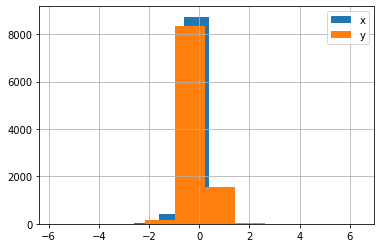

In [31]:
import matplotlib.pyplot as plt
(waypoint_df['x'] - waypoint_df['_x']).hist(label='x')
(waypoint_df['y'] - waypoint_df['_y']).hist(label='y')
plt.legend()

In [32]:
sub = sub.merge(waypoint_df[['site_path_timestamp', '_x', '_y']], on='site_path_timestamp').set_index('site_path_timestamp')
sub = sub.drop(['x','y'], axis=1).rename(columns={'_x':'x', '_y':'y'})
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,89.343513,103.353050
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.457899,102.626241
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.770599,105.976670
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.848985,107.764220
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.426764,106.721870
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,214.992290,97.882242
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,212.975098,98.706818
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,208.254787,105.239984


In [33]:
sub.to_csv(EXP_NAME + '_sub.csv')

## 後処理

## cost minimaization

In [34]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [35]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [36]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    example = read_data_file(root_dir/ f'indoor-location-navigation/test/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def correct_path_train(args):
    #print(args)
    (site_id, path, floor), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor}/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)


<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-36-a1a172f865b0>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if current_state is 'above':


In [37]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [38]:
%%time

oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
    dfs = tqdm(dfs)
    dfs = list(dfs)

oof_post_process = pd.concat(dfs).sort_index()
oofs_df['oof_min_x'] = oof_post_process['x']
oofs_df['oof_min_y'] = oof_post_process['y']

# 元に戻す
oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})
oofs_df

10836it [05:28, 32.95it/s]
CPU times: user 53.4 s, sys: 12.7 s, total: 1min 6s
Wall time: 5min 33s


,timestamp,target_x,target_y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.703384,35.896935,0.050015,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.414585,38.913620
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.085648,33.331852,0.051606,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.418304,38.917758
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.479462,31.129669,0.055450,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.369527,30.696574
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,83.046516,28.305487,0.105547,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.372180,30.707780
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.903687,25.688530,0.113001,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.378023,30.722282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.722580,102.947876,0.051249,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.841040,102.959105
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.081009,104.781708,0.048083,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.826999,102.950056
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.765640,101.219009,0.045495,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.397333,103.562484
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.395981,99.917511,0.047748,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.389297,103.554136


In [39]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:5.900770499576758


In [40]:
# waypoint補正後のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['iCV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:6.113073899965642


In [41]:
sub = sub.reset_index()
sub_org = sub.copy()
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)
sub

,site_path_timestamp,floor,x,y,site,path,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.343513,103.353050,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9.0
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.457899,102.626241,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9017.0
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.770599,105.976670,5a0546857ecc773753327266,046cfa46be49fc10834815c6,15326.0
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.848985,107.764220,5a0546857ecc773753327266,046cfa46be49fc10834815c6,18763.0
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.426764,106.721870,5a0546857ecc773753327266,046cfa46be49fc10834815c6,22328.0
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,214.992290,97.882242,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,82589.0
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,212.975098,98.706818,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,85758.0
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,208.254787,105.239984,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,90895.0
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.149197,108.066108,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,96899.0


In [42]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
    dfs = tqdm(dfs)
    dfs = list(dfs)
new_sub = pd.concat(dfs).sort_values('site_path_timestamp')
new_sub

626it [00:49, 12.64it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,91.852248,97.180211
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,82.436113,99.677833
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.219752,104.760100
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.051741,108.508572
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.534958,112.191119
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,212.176918,97.669079
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.384175,101.089948
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.624574,106.829837
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,199.521384,111.216071


In [43]:
new_sub.to_csv(RUN_NAME + '_cost_sub.csv', index=False)

## snap to grid

In [44]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [45]:

oofs_df

,timestamp,target_x,target_y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.703384,35.896935,0.050015,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.414585,38.913620
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.085648,33.331852,0.051606,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.418304,38.917758
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.479462,31.129669,0.055450,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.369527,30.696574
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,83.046516,28.305487,0.105547,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.372180,30.707780
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.903687,25.688530,0.113001,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.378023,30.722282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.722580,102.947876,0.051249,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.841040,102.959105
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.081009,104.781708,0.048083,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.826999,102.950056
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.765640,101.219009,0.045495,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.397333,103.562484
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.395981,99.917511,0.047748,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.389297,103.554136


In [46]:
train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
# 線形補完しているwaypointをtrain_waypoints（grid）とする。gridを増やすのが狙い。
# train_waypoints = oofs_df[['oof_x', 'oof_y', 'timestamp', 'site_id_str', 'floor', 'floor_str', 'path']]
# train_waypoints = train_waypoints.rename(columns={'oof_x':'x', 'oof_y':"y", 'site_id_str':"site", 'floor_str':'floorNo'})

snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
snap_df = sub_process(snap_df, train_waypoints)
snap_df = add_xy(snap_df)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
    d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

# 上書き
snap_df = pd.concat(ds).sort_index()
snap_df

100%|██████████| 139/139 [01:40<00:00,  1.39it/s]


,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint,xy,matched_point,oof_min_snap_x,oof_min_snap_y
0,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,84.414585,38.913620,F3,False,"(84.41458499795694, 38.91361992872462)","(87.76849, 39.768955)",87.76849,39.768955
1,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,84.418304,38.917758,F3,False,"(84.41830406599334, 38.91775804315459)","(87.76849, 39.768955)",87.76849,39.768955
2,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,85.369527,30.696574,F3,False,"(85.36952733475462, 30.696573542317214)","(84.22669, 27.13862)",84.22669,27.138620
3,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,85.372180,30.707780,F3,False,"(85.37218017802809, 30.707779983820966)","(84.22669, 27.13862)",84.22669,27.138620
4,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,85.378023,30.722282,F3,False,"(85.37802323222004, 30.722281752217377)","(84.22669, 27.13862)",84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,202.841040,102.959105,B1,False,"(202.84103956303792, 102.95910511275346)","(204.21092, 106.165436)",204.21092,106.165436
256745,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,202.826999,102.950056,B1,False,"(202.8269992128702, 102.9500555123995)","(204.21092, 106.165436)",204.21092,106.165436
256746,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,210.397333,103.562484,B1,False,"(210.397332589343, 103.56248378673013)","(208.15857, 104.7078)",208.15857,104.707800
256747,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,210.389297,103.554136,B1,False,"(210.389297290797, 103.55413627435425)","(208.15857, 104.7078)",208.15857,104.707800


In [47]:
oofs_df['oof_min_snap_x'] = snap_df['oof_min_snap_x']
oofs_df['oof_min_snap_y'] = snap_df['oof_min_snap_y']
oofs_df

,timestamp,target_x,target_y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y,oof_min_snap_x,oof_min_snap_y
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.703384,35.896935,0.050015,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.414585,38.913620,87.76849,39.768955
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.085648,33.331852,0.051606,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.418304,38.917758,87.76849,39.768955
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,85.479462,31.129669,0.055450,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.369527,30.696574,84.22669,27.138620
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,83.046516,28.305487,0.105547,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.372180,30.707780,84.22669,27.138620
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.903687,25.688530,0.113001,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,85.378023,30.722282,84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.722580,102.947876,0.051249,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.841040,102.959105,204.21092,106.165436
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.081009,104.781708,0.048083,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,202.826999,102.950056,204.21092,106.165436
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.765640,101.219009,0.045495,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.397333,103.562484,208.15857,104.707800
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,206.395981,99.917511,0.047748,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,210.389297,103.554136,208.15857,104.707800


In [48]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:5.390805396132097


In [49]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['iCV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:6.0205257293972805


In [50]:
# x_pred = oofs_df["oof_min_snap_x"]
# y_pred = oofs_df["oof_min_snap_y"]
# f_pred = oofs_df["floor"]  # 正解を与える
# x_true = oofs_df["wifi_x"]
# y_true = oofs_df["wifi_y"]
# f_true = oofs_df["floor"]
# site_arr = oofs_df["site_id_str"]
# df_result_site3 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
# df_result_site3.style.bar(subset=['n_sample', 'score'], color=['teal'])

In [51]:
# site_eval_report(df_result_site3)

In [52]:
# train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')

new_sub = sub_process(new_sub, train_waypoints)
new_sub = add_xy(new_sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in new_sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

new_sub2 = pd.concat(ds)

In [53]:
new_sub2 = new_sub2[['site_path_timestamp','floor','x_','y_']].sort_index()
new_sub2 = new_sub2.rename(columns={'x_':'x', 'y_':'y'})
new_sub2

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.360190,99.075780
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.450550
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,88.779945,108.933240
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.917800
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,215.262270,97.973610
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.662190,104.351776
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.825880,109.711815


In [54]:
new_sub2.to_csv(RUN_NAME + '_cost_snap_sub.csv', index=False)

In [55]:
# import matplotlib.pyplot as plt
# df_result_site1['score'].plot(label='oof')
# df_result_site2['score'].plot(label='cost')
# df_result_site3['score'].plot(label='cost+snap')
# plt.legend()
# plt.grid()
# plt.savefig('site_result.png')

In [56]:
wandb.finish()

Loss/val,39.11964
Loss/xy,39.11964
MPE/val,7.42513
iMPE/val,6.94424
epoch,194
trainer/global_step,78389
_runtime,936
_timestamp,1619242033
_step,194


Loss/val,█▆▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▆▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▇▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iMPE/val,█▇▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
